## Preparing the notebook

In [7]:
from google.colab import drive

drive.mount('/content/drive')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
%%capture
!pip install torch transformers == 4.28.0 datasets matplotlib seaborn pytorch_transformers

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [53]:
import os, torch, random, sklearn.metrics as tool
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset
from tqdm import tqdm, trange
from pytorch_transformers import WarmupLinearSchedule
from sklearn.metrics import confusion_matrix
import pandas as pd, matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from transformers import AdamW, AutoModel
from datasets import Dataset
import seaborn as sns
from tqdm.notebook import trange, tqdm
from pytorch_transformers.modeling_utils import WEIGHTS_NAME, CONFIG_NAME
from sklearn.metrics import classification_report
from pytorch_transformers.modeling_bert import BertPreTrainedModel, BertModel
import warnings
from transformers import AutoTokenizer
from torch import nn
from pytorch_transformers.optimization import AdamW
from datasets import load_from_disk
import nltk
from nltk.corpus import stopwords
import pickle

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [10]:
warnings.filterwarnings('always')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

MAX_NO_LABEL = 25

# Fix the random seeds
SEED = 1
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

TEXT = 'TEXT'
LABEL = 'LABEL'
LOCATION = 'LOCATION'
ABV = 'ABV'


class Path:
    BASE = os.path.join(os.getcwd(), 'drive', 'MyDrive')
    DB = os.path.join(BASE, 'datasets', 'med')
    TRANSFORMER_MODELS = os.path.join(BASE, "Transformers")
    TRAIN_SPLIT = os.path.join(DB, 'train.csv')
    VALID_SPLIT = os.path.join(DB, 'valid.csv')
    TEST_SPLIT = os.path.join(DB, 'test.csv')
    TRAIN = os.path.join(DB, 'train')
    VAL = os.path.join(DB, 'val')
    TEST = os.path.join(DB, 'test')
    CHECKPOINT = os.path.join(BASE, 'checkpoint')


class ModelName:
    BIOBERT = "dmis-lab/biobert-base-cased-v1.1"
    BERT_TINY = 'prajjwal1/bert-tiny'
    SCIBERT = "allenai/scibert_scivocab_uncased"
    BIOGPT = 'microsoft/biogpt'

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:91

## Preparing the data

#### terminal

In [ ]:
# !mkdir ../root/.kaggle && mv kaggle.json ../root/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download xhlulu / medal-emnlp

100% 6.82G/6.82G [00:54<00:00, 154MB/s]
100% 6.82G/6.82G [00:54<00:00, 133MB/s]


In [ ]:
!unzip medal-emnlp.zip

Archive:  medal-emnlp.zip
  inflating: full_data.csv           
  inflating: pretrain_subset/test.csv  
  inflating: pretrain_subset/train.csv  
  inflating: pretrain_subset/valid.csv  


#### 1. One-time preprocessing

In [ ]:
train = pd.read_csv(Path.TRAIN_SPLIT)
val = pd.read_csv(Path.VALID_SPLIT)
test = pd.read_csv(Path.TEST_SPLIT)

In [ ]:
def abbreviation(df):
    return df.apply(lambda row: row.TEXT.split()[row.LOCATION], axis=1)

In [ ]:
train['ABV'] = abbreviation(train)
val['ABV'] = abbreviation(val)
test['ABV'] = abbreviation(test)

In [ ]:
train.shape, val.shape, test.shape

((3000000, 5), (1000000, 5), (1000000, 5))

In [ ]:
data = pd.concat([train, val, test]).reset_index(drop=True)
data.shape

(5000000, 5)

In [ ]:
gp = data.groupby(ABV)
print(
    f"We have a total of {len(gp)} abbreviations.\nThe most supportive one has a support of {max(gp.size())}\nand the least supportive one has a support of {min(gp.size())}")

We have a total of 5798 abbreviations.
The most supportive one has a support of 23774
and the least supportive one has a support of 10


<Axes: ylabel='Count'>

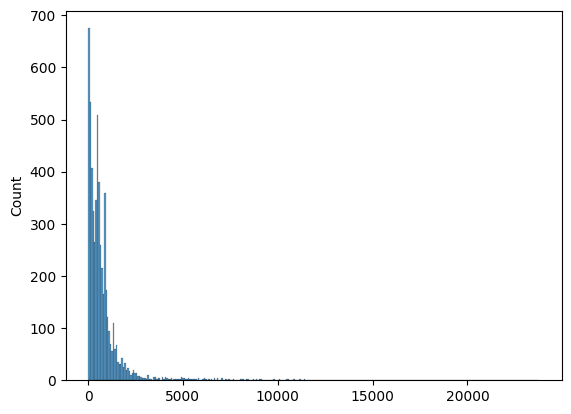

In [ ]:
sns.histplot(gp.size())

In [ ]:
target_abvs = []
target_dfs = []
i = 0
# Create an empty DataFrame to store the filtered data
filtered_data = []
for abv, df in gp:
    if i == 4:
        break
    if df.LABEL.unique().shape[0] >= 20 and df.LABEL.unique().shape[0] < 30:
        i += 1
        # Iterate over each unique label
        for label in df.LABEL.unique():
            label_df = df[df.LABEL == label]
            if label_df.shape[0] > 30:
                # Filter the DataFrame for the current label and take 30 samples
                label_samples = label_df.sample(n=30, random_state=1)
            else:
                label_samples = label_df
            # Append the filtered samples to the final DataFrame
            filtered_data.append(label_samples)
        target_abvs.append(abv)
# Reset the index of the filtered DataFrame and concat all of them
data = pd.concat(filtered_data, ignore_index=True)

In [ ]:
digits = [
    "one",
    "two",
    "three",
    "four",
    "five",
    "six",
    "seven",
    "eight",
    "nine",
    "ten",

    "first",
    "second",
    "third",
    "fourth",
    "fifth",
    "sixth",
    "seventh",
    "eighth",
    "ninth",
    "tenth",
]

In [ ]:
# Labels with different number of words than their Abbreviation letters
grouped_data = data.groupby('ABV')
corrected_labels = []
bad_labels = []
abv2labels = {}
bad_label2good_label = {}
for abv, df in grouped_data:
    abv2labels[abv] = df.LABEL.unique()
    for label in abv2labels[abv]:
        label_with_no_stop_word = ' '.join([word for word in label.split() if word.lower() not in stop_words])
        if label_with_no_stop_word != label:
            bad_label2good_label[label] = label_with_no_stop_word, abv
    odd_labels = [label for label in abv2labels[abv] if
                  len([word for word in label.split() if word.lower() not in stop_words]) > len(abv)]
    if odd_labels:
        for odd_label in odd_labels:
            label_words = odd_label.split()
            correct_words = []
            i = 0
            j = 0
            while i < len(label_words) and j < len(abv):
                word = label_words[i]
                if word.lower() not in stop_words:
                    if word.startswith(abv[j].lower()):
                        correct_words.append(word)
                        j += 1
                    elif j != 0 and word.startswith(abv[j - 1].lower()):
                        correct_words.append(word)
                i += 1
            while i < len(label_words):
                word = label_words[i]
                if word.lower() not in stop_words and word.startswith(abv[j - 1].lower()):
                    correct_words.append(word)
                i += 1
            i = 0
            while i < len(label_words):
                word = label_words[i]
                if word in digits:
                    correct_words.append(word)
                i += 1
            correct_label = " ".join(correct_words)
            if correct_label:
                bad_label2good_label[odd_label] = correct_label, abv
bad_labels += [  # Samples with these labels has to be removed from the dataset.
    'dementia of the alzheimer type',
    # 'constant dim red light'
    # 'plasma potassium concentration',
    # 'protein kinase c activator',
    # 'glucose disposal rate',
    # 'urinary flow rate',
]
bad_label2good_label |= {  # Here we can manually update the already automatic created mapping above
    # 'lymph protein concentration': ('lymph protein concentration', 'CL'),
    # 'dementia of the alzheimer type': ('dementia of the alzheimer type', 'AD'),
    # 'constant dim red light': ('constant dim red light', 'DD'),
}
bad_label2good_label

In [ ]:
# apply dictionary to column using map function
mapped_label = data.LABEL.map(lambda x: bad_label2good_label.get(x, x)[0] if isinstance(bad_label2good_label.get(x, x),
                                                                                        tuple) else bad_label2good_label.get(
    x, x))
print((data.LABEL != mapped_label).sum())
data.LABEL = mapped_label
# Filter the DataFrame to remove the rows with a bad label
bad_labels_mask = data['LABEL'].isin(bad_labels)
print(data[bad_labels_mask].shape[0])
data = data[~bad_labels_mask]

149
30


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
grouped_data = data.groupby('ABV')
abv2prompt = {}
bad_label2good_label = {}
for abv, df in grouped_data:
    labels = df.LABEL.unique()
    abv2prompt[abv] = lambda label: '{} and {} both include the following letters: {}.'.format(
        abv,
        label,
        ' and '.join([f"\'{letter.lower()}\'" for letter in abv if letter not in ['-', '_']])
    )

In [ ]:
grouped_data = data.groupby(ABV)
abv2ambiguity = {}
abv2labels = {}
for abv, df in grouped_data:
    degree_of_ambiguity = len(df.LABEL.unique())
    abv2ambiguity[abv] = degree_of_ambiguity
    abv2labels[abv] = df.LABEL.unique()
print("Minimum ambiguity               :", min(abv2ambiguity.values()))
print("Maximum ambiguity               :", max(abv2ambiguity.values()))

Minimum ambiguity               : 20
Maximum ambiguity               : 23


In [ ]:
previous_sample_no = data.shape[0]
print(f"Before removing abvs we have {previous_sample_no} samples.")
abvs_with_no_ambiguity = [abv for abv in abv2ambiguity.keys() if abv2ambiguity[abv] == 1]
data = data[~data.ABV.isin(abvs_with_no_ambiguity)]
print(
    f"After removing abvs we have {data.shape[0]} samples." +
    f"\nOverall we are removing {previous_sample_no - data.shape[0]} number of samples."
)

Before removing abvs we have 10234 samples.
After removing abvs we have 8974 samples.
Overall we are removing 1260 number of samples.


In [ ]:
def get_common_words(X):
    common_words = []
    for item in X:
        words = item.split()
        for word in words:
            if any(word in other_item.split() and len(words) != len(other_item.split()) for other_item in X if
                   other_item != item):
                common_words.append(item)
                break
        return common_words

In [ ]:
texts = []
for i, row in enumerate(data.iterrows()):
    text_split = row[1].TEXT.split()
    loc = row[1].LOCATION
    shortened_text = text_split[loc - 30 if loc > 30 else 0:loc + 30 if loc + 30 < len(text_split) else len(text_split)]
    text_joined = " ".join(shortened_text)
    texts.append(text_joined)
data[TEXT] = texts

In [ ]:
data.to_pickle(f'drive/MyDrive/data.pkl')
with open(f'drive/MyDrive/abv2ambiguity.pickle', 'wb') as handle:
    pickle.dump(abv2ambiguity, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open(f'drive/MyDrive/abv2labels.pickle', 'wb') as handle:
    pickle.dump(abv2labels, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open(f'drive/MyDrive/abv2prompt.pickle', 'wb') as handle:
    pickle.dump(abv2prompt, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# create train, val and test data
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.50, random_state=1, stratify=X['ABV'])
train_dataset, test_dataset = train_test_split(data, test_size=0.35, random_state=1, stratify=data[LABEL])

In [ ]:
# X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.50, random_state=1);
val_dataset, test_dataset = train_test_split(test_dataset, test_size=0.50, random_state=1,
                                             stratify=test_dataset[LABEL]);

In [ ]:
train_dataset = train_dataset.reset_index(drop=True)
val_dataset = val_dataset.reset_index(drop=True)
test_dataset = test_dataset.reset_index(drop=True)

In [ ]:
print(f'Training data has a shape equal to  : {train_dataset.shape}')
print(f'Validation data has a shape equal to: {val_dataset.shape}')
print(f'Testing data has a shape equal to   : {test_dataset.shape}')

Training data has a shape equal to  : (1702, 5)
Validation data has a shape equal to: (458, 5)
Testing data has a shape equal to   : (459, 5)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
train_dataset = Dataset.from_pandas(train_dataset)
val_dataset = Dataset.from_pandas(val_dataset)
test_dataset = Dataset.from_pandas(test_dataset)

In [ ]:
train_dataset.save_to_disk(Path.TRAIN)
val_dataset.save_to_disk(Path.VAL)
test_dataset.save_to_disk(Path.TEST)

## Transformer Models

In [ ]:
data = pd.read_pickle(f'drive/MyDrive/data.pkl')

grouped_data = data.groupby('ABV')
abv2prompt = {}
abv2ambiguity = {}
abv2labels = {}

for abv, df in grouped_data:
    labels = df.LABEL.unique()
    abv2prompt[abv] = lambda label: '{} and {} both include the following letters: {}.'.format(
        abv,
        label,
        ' and '.join([f"\'{letter.lower()}\'" for letter in abv if letter not in ['-', '_']])
    )
for abv, df in grouped_data:
    degree_of_ambiguity = len(df.LABEL.unique())
    abv2ambiguity[abv] = degree_of_ambiguity
    abv2labels[abv] = df.LABEL.unique()
print("Minimum ambiguity               :", min(abv2ambiguity.values()))
print("Maximum ambiguity               :", max(abv2ambiguity.values()))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Minimum ambiguity               : 18
Maximum ambiguity               : 23


In [ ]:
train_dataset = load_from_disk(Path.TRAIN)
val_dataset = load_from_disk(Path.VAL)
test_dataset = load_from_disk(Path.TEST)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
patterns_optimizer = {
    'additional_layers': ['additional'],
    'top_layer': ['additional', 'bert_model.encoder.layer.11.'],
    'top4_layers': [
        'additional',
        'bert_model.encoder.layer.11.',
        'encoder.layer.10.',
        'encoder.layer.9.',
        'encoder.layer.8',
    ],
    'all_encoder_layers': ['additional', 'bert_model.encoder.layer', 'GNN.layers', 'mu'],
    'all': ['additional', 'bert_model.encoder.layer', 'bert_model.embeddings'],
}

params = {
    'input_path': '/content/drive/MyDrive/data',
    'output_path': '/content/drive/MyDrive/output',
    'train_batch_size': 2,
    'eval_batch_size': 28,
    'seed': 1,
    'shuffle': False,
    'no_cuda': False,
    'data_parallel': False,
    'debug': False,
    'print_interval': 10,
    'eval_interval': 860,
    'max_seq_len': 128,
    'gap': 0.1,
    'mu': 0.5,
    'gradient_accumulation_steps': 1,
    'max_grad_norm': 1,
    'lowercase': False,
    'path_to_model': None,
    'type_optimization': 'all_encoder_layers',
    'learning_rate': 3e-05,
    'num_train_epochs': 2,
    'warmup_proportion': 0.1
}

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
train_dataset, val_dataset, test_dataset

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(Dataset({
     features: ['ABSTRACT_ID', 'TEXT', 'LOCATION', 'LABEL', 'ABV'],
     num_rows: 1721
 }),
 Dataset({
     features: ['ABSTRACT_ID', 'TEXT', 'LOCATION', 'LABEL', 'ABV'],
     num_rows: 464
 }),
 Dataset({
     features: ['ABSTRACT_ID', 'TEXT', 'LOCATION', 'LABEL', 'ABV'],
     num_rows: 464
 }))

In [ ]:
def baseline(data=val_dataset):
    y_true = data[LABEL]
    abv = data[ABV]
    y_pred = []
    for i in tqdm(range(data.num_rows)):
        input_id = []
        original_candidates = list(abv2labels[data[ABV][i]])
        context = data[TEXT][i]
        highest_score = 0
        best_candidate = ''
        for candidate in original_candidates:
            score = 0
            candidate_words = candidate.split()
            for word in candidate_words:
                if word in context:
                    score += 1
            score /= len(candidate_words)
            if score > highest_score:
                highest_score = score
                best_candidate = candidate
        if best_candidate == '':
            best_candidate = original_candidates[0]
        y_pred.append(best_candidate)
    return y_true, y_pred, abv


class BertModel(torch.nn.Module):
    def __init__(self, model_name):
        super(BertModel, self).__init__()
        self.bert_model = AutoModel.from_pretrained(model_name)
        dim = self.bert_model.config.hidden_size
        self.additional_linear = nn.Linear(dim, 1)
        self.config = self.bert_model.config

    def forward(self, input):
        bert_pooler = self.bert_model(input)
        out = self.additional_linear(bert_pooler[1]).squeeze()
        return out


class BertPrompt(torch.nn.Module):
    def __init__(self, model_name, model_path):
        super(BertPrompt, self).__init__()
        self.device = torch.device(
            "cuda" if torch.cuda.is_available() else "cpu"
        )
        self.n_gpu = torch.cuda.device_count()

        self.model = BertModel(model_name)
        self.tokenizer = AutoTokenizer.from_pretrained(
            model_name,
            use_fast=True,
        )

        if model_path is not None:
            print("loading model from {}".format(model_path))
            if torch.cuda.is_available():
                state_dict = torch.load(model_path)
            else:
                state_dict = torch.load(model_path, map_location=torch.device('cpu'))
            self.model.load_state_dict(state_dict, strict=False)

        # To Cuda
        self.model = self.model.to(self.device)

        # For DataParallel
        self.data_parallel = True
        if self.data_parallel:
            self.model = torch.nn.DataParallel(self.model)

        self.loss_fuc = nn.CrossEntropyLoss()
        self.gap = 0.2
        self.mu = 0.5

    def save_model(self, output_dir):
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        model_to_save = self.model.module if hasattr(self.model, "module") else self.model
        output_model_file = os.path.join(output_dir, WEIGHTS_NAME)
        output_config_file = os.path.join(output_dir, CONFIG_NAME)
        torch.save(model_to_save.state_dict(), output_model_file)
        model_to_save.config.to_json_file(output_config_file)
        self.tokenizer.save_vocabulary(output_dir)

    def forward(self, sequence, label=None, original_labels_length=None):
        batch_size = sequence.size(0)
        sequence = sequence.view(-1, sequence.size(-1))
        # seq from [2, 18, 128] to [36, 128]
        scores = self.model(sequence)
        # model gets [36, 128] and returns [36]
        scores = scores.view(batch_size, -1)
        # we then change the score view to [2, 18]
        try:
            loss = self.loss_fuc(scores, label)
            scores = scores.softmax(dim=-1)
            for index, score in enumerate(scores):
                original_candidates = score[:original_labels_length[index]]
                additional_negative_candidates = score[original_labels_length[index]:]
                hinge_loss = self.mu * max(max(additional_negative_candidates) + self.gap - min(original_candidates), 0)
                loss += hinge_loss
            return loss
        except:
            return scores


class Prompts:
    NO = 'no'
    FIRST = 'fisrt'
    ABV = 'abv'
    ALL = 'all'

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [2]:
class TrasformerModel:
    def __init__(self, model_name, debug=True, which_prompts=Prompts.ALL,
                 train_batch_size=params["train_batch_size"] // params["gradient_accumulation_steps"],
                 eval_batch_size=params["eval_batch_size"], num_train_epochs=params["num_train_epochs"],
                 grad_acc_steps=params["gradient_accumulation_steps"], eval_interval=params["eval_interval"],
                 print_interval=params["print_interval"], max_grad_norm=params["max_grad_norm"],
                 max_seq_len=params["max_seq_len"], path_to_model=params.get("path_to_model", None)):

        self.which_prompts = which_prompts
        self.debug = debug
        self.train_batch_size = train_batch_size
        self.eval_batch_size = eval_batch_size
        self.num_train_epochs = num_train_epochs
        self.grad_acc_steps = grad_acc_steps
        self.eval_interval = eval_interval
        self.print_interval = print_interval
        self.max_grad_norm = max_grad_norm
        name = 'tiny' if model_name == ModelName.BERT_TINY else 'biobert' if model_name == ModelName.BIOBERT_LAB else 'scibert'
        self.save_model_in = os.path.join(Path.BASE, f'{name}_20-30_{which_prompts}')
        self.path_to_model = path_to_model
        self.all_original_versions = sum(list(map(list, abv2labels.values())), [])
        self.max_seq_len = max_seq_len

        self.model_name = model_name
        self.model = BertPrompt(self.model_name, self.path_to_model)
        self.tokenizer = self.model.tokenizer

        self.train = None
        self.val = None
        self.test = None
        self.y_train = None
        self.y_val = None
        self.y_test = None

        self.start_epoch = 0
        if params["path_to_model"]:
            t = params["path_to_model"].split('/')[-2]  #epoch_**
            assert t.split('_')[0] == 'epoch', print("Wrong checkpoint dir")
            start_epoch = int(t.split('_')[-1]) + 1
            print("Continue training at epoch: " + str(start_epoch))
        if not os.path.exists(self.save_model_in):
            os.makedirs(self.save_model_in)
        self.prepare_train_val_test();

    def prepare_input_features(self, data):
        tokenized_examples = {}
        tokenized_examples['input_ids'] = []
        tokenized_examples['labels'] = []
        tokenized_examples['no_labels'] = []
        tokenized_examples['abv'] = []
        for i in range(len(data[ABV])):
            input_id = []
            tokenized_examples['abv'].append(self.tokenizer.encode(data[ABV][i], padding=True))
            tokenized_examples['no_labels'].append(
                abv2ambiguity[data[ABV][i]])  # length of possible labels for each acronym
            original_candidates = list(
                abv2labels[data[ABV][i]])  # list of all possible labels for ABBREVIATION in this sample
            additional_negative_candidates = []
            already_chosen = []
            j = len(original_candidates)
            while j < MAX_NO_LABEL:
                random_candidate = self.all_original_versions[
                    np.random.randint(low=0, high=len(self.all_original_versions) - 1)]
                while random_candidate in original_candidates or random_candidate in already_chosen:
                    random_candidate = self.all_original_versions[
                        np.random.randint(low=0, high=len(self.all_original_versions) - 1)]
                additional_negative_candidates.append(random_candidate)
                already_chosen.append(random_candidate)
                j += 1
            candidates = original_candidates + additional_negative_candidates
            tokenized_examples['labels'].append(
                candidates.index(data[LABEL][i]))  # index of correct expansion for this sample

            tokenized_context = self.tokenizer.encode(data[TEXT][i])
            for candidate in candidates:
                prompt1 = self.tokenizer.encode("the meaning of " + data[ABV][i] + " is or equals " + candidate)
                prompt2 = self.tokenizer.encode(abv2prompt[data[ABV][i]](candidate))
                prompts = {
                    Prompts.NO: [],
                    Prompts.FIRST: prompt1,
                    Prompts.ABV: prompt2,
                    Prompts.ALL: prompt1 + prompt2,
                }
                tokenized_context_prompt = tokenized_context + self.tokenizer.encode(candidate) + prompts[
                    self.which_prompts]
                input_id.append(tokenized_context_prompt + [0] * (self.max_seq_len - len(tokenized_context_prompt))
                                if len(tokenized_context_prompt) < self.max_seq_len else tokenized_context_prompt[
                                                                                         -self.max_seq_len:])

            tokenized_examples['input_ids'].append(input_id)
            max_len_abv = max(map(len, tokenized_examples['abv']))
            for i, tokenized_abv in enumerate(tokenized_examples['abv']):
                padding = [0] * int((max_len_abv - len(tokenized_abv)))
                tokenized_examples['abv'][i].extend(padding)
        return tokenized_examples

    def prepare_train_val_test(self):
        # Convert the input and label columns to tensors and Create a TensorDataset from the tensors
        self.train = train_dataset.map(self.prepare_input_features, batched=True)
        self.train = TensorDataset(
            *[torch.tensor(self.train[key]) for key in ['input_ids', 'labels', 'no_labels', 'abv']])
        self.train_dataloader = DataLoader(
            self.train, sampler=RandomSampler(self.train) if params["shuffle"] else SequentialSampler(self.train),
            batch_size=self.train_batch_size
        )
        self.val = val_dataset.map(self.prepare_input_features, batched=True)
        self.val = TensorDataset(*[torch.tensor(self.val[key]) for key in ['input_ids', 'labels', 'no_labels', 'abv']])
        self.valid_dataloader = DataLoader(
            self.val, sampler=SequentialSampler(self.val), batch_size=self.eval_batch_size
        )
        self.test = test_dataset.map(self.prepare_input_features, batched=True)
        self.test = TensorDataset(
            *[torch.tensor(self.test[key]) for key in ['input_ids', 'labels', 'no_labels', 'abv']])
        self.test_dataloader = DataLoader(
            self.test, sampler=SequentialSampler(self.test), batch_size=self.eval_batch_size
        )
        return self

    def _get_optimizer(self, type_optimization=params["type_optimization"], learning_rate=params["learning_rate"]):
        """ Optimizes the network with AdamWithDecay
            Except parameters with 'bias', 'gamma' and 'beta' in their name all other parameters must have a weight_decay of 0.01
        """

        parameters_with_decay = []
        parameters_with_decay_names = []
        parameters_without_decay = []
        parameters_without_decay_names = []
        no_decay = ['bias', 'gamma', 'beta']
        patterns = patterns_optimizer[type_optimization]

        for n, p in self.model.named_parameters():
            if any(t in n for t in patterns):
                if any(t in n for t in no_decay):
                    parameters_without_decay.append(p)
                    parameters_without_decay_names.append(n)
                else:
                    parameters_with_decay.append(p)
                    parameters_with_decay_names.append(n)

        optimizer_grouped_parameters = [
            {'params': parameters_with_decay, 'weight_decay': 0.01},
            {'params': parameters_without_decay, 'weight_decay': 0.0},
        ]

        return AdamW(
            optimizer_grouped_parameters,
            lr=learning_rate,
            correct_bias=False
        )

    def _get_scheduler(self, optimizer, len_train_data):
        num_train_steps = int(len_train_data / self.train_batch_size / self.grad_acc_steps) * self.num_train_epochs
        num_warmup_steps = int(num_train_steps * params["warmup_proportion"])
        scheduler = WarmupLinearSchedule(
            optimizer, warmup_steps=num_warmup_steps, t_total=num_train_steps,
        )
        return scheduler

    def train_model(self):
        self.model.train()
        optimizer = self._get_optimizer()
        scheduler = self._get_scheduler(optimizer, len(self.train))
        for epoch_idx in trange(self.start_epoch, int(self.num_train_epochs), desc="Epoch"):
            iter_ = tqdm(self.train_dataloader, desc="Batch", leave=False)
            for step, batch in enumerate(iter_):
                input_ids, label, original_labels_length, _ = tuple(t.to(self.model.device) for t in batch)
                loss = self.model(input_ids, label, original_labels_length)

                if self.grad_acc_steps > 1:
                    loss = loss / self.grad_acc_steps

                iter_.set_postfix(loss=loss.item())

                loss.backward()

                if (step + 1) % self.grad_acc_steps == 0:
                    torch.nn.utils.clip_grad_norm_(
                        self.model.parameters(), self.max_grad_norm
                    )
                    optimizer.step()
                    scheduler.step()
                    optimizer.zero_grad()

                if (step + 1) % (self.eval_interval * self.grad_acc_steps) == 0:
                    print("Evaluation on the development dataset")
                    self.evaluate(self.valid_dataloader)
                    self.model.train()
            epoch_output_folder_path = os.path.join(
                self.save_model_in, "epoch_{}".format(epoch_idx)
            )
            self.model.save_model(epoch_output_folder_path)

    def evaluate(self, eval_dataloader=None):
        eval_dataloader = eval_dataloader or self.valid_dataloader
        self.model.eval()
        iter_ = tqdm(eval_dataloader, desc="Evaluation")

        y_true = []
        y_pred = []
        for step, batch in enumerate(iter_):
            batch = tuple(t.to(self.model.device) for t in batch)
            input_ids, label, _, _ = batch
            with torch.no_grad():
                logits = self.model(input_ids)

            logits = logits.detach().cpu().numpy()
            y_true.extend(label.detach().cpu().numpy())
            y_pred.extend(np.argmax(logits, axis=1))

        print()
        print('Macro: precision: {}, f1 score: {}, recall: {}'.format(
            tool.precision_score(y_true, y_pred, average='macro', zero_division=0),
            tool.f1_score(y_true, y_pred, average='macro', zero_division=0),
            tool.recall_score(y_true, y_pred, average='macro', zero_division=0),
        ))

    def predict(self, data=None):
        data = data or self.test_dataloader
        self.model.eval()

        y_true = []
        y_pred = []
        abvs = []
        iter_ = tqdm(data, desc="Evaluation")
        for step, batch in enumerate(iter_):
            batch = tuple(t.to(self.model.device) for t in batch)
            input_ids, label, _, abv = batch
            with torch.no_grad():
                logits = self.model(input_ids)
            abvs.extend(list(
                map(lambda x: ' '.join(self.tokenizer.decode([el for el in x if el != 0]).split()[1:-1]).upper(), abv)))
            logits = logits.detach().cpu().numpy()
            y_true.extend(label.detach().cpu().numpy())
            y_pred.extend(np.argmax(logits, axis=1))
        return y_true, y_pred, abvs

### Tiny bert

#### NO prompts

In [ ]:
bert = TrasformerModel(ModelName.BERT_TINY, which_prompts=Prompts.NO, num_train_epochs=8)
bert.train_model();

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:

Map:   0%|          | 0/1721 [00:00<?, ? examples/s]

Map:   0%|          | 0/464 [00:00<?, ? examples/s]

Map:   0%|          | 0/464 [00:00<?, ? examples/s]

Epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Batch:   0%|          | 0/861 [00:00<?, ?it/s]

Evaluation on the development dataset


Evaluation:   0%|          | 0/17 [00:00<?, ?it/s]


Macro: precision: 0.08242507228084353, f1 score: 0.0478204896181324, recall: 0.07200207039337474
Evaluation on the development dataset


Evaluation:   0%|          | 0/17 [00:00<?, ?it/s]


Macro: precision: 0.12386236077481944, f1 score: 0.07424888551266946, recall: 0.09305072463768116


Batch:   0%|          | 0/861 [00:00<?, ?it/s]

Evaluation on the development dataset


Evaluation:   0%|          | 0/17 [00:00<?, ?it/s]


Macro: precision: 0.22149912165129557, f1 score: 0.15463858884647844, recall: 0.14963848631239934
Evaluation on the development dataset


Evaluation:   0%|          | 0/17 [00:00<?, ?it/s]


Macro: precision: 0.26499992116921817, f1 score: 0.228683149012548, recall: 0.22551679319070622


Batch:   0%|          | 0/861 [00:00<?, ?it/s]

Evaluation on the development dataset


Evaluation:   0%|          | 0/17 [00:00<?, ?it/s]


Macro: precision: 0.31230839190326853, f1 score: 0.2560975370263203, recall: 0.24811352657004832
Evaluation on the development dataset


Evaluation:   0%|          | 0/17 [00:00<?, ?it/s]


Macro: precision: 0.28444352706451215, f1 score: 0.24691330453139984, recall: 0.24715424430641822


Batch:   0%|          | 0/861 [00:00<?, ?it/s]

Evaluation on the development dataset


Evaluation:   0%|          | 0/17 [00:00<?, ?it/s]


Macro: precision: 0.3162535420265599, f1 score: 0.28630367064762063, recall: 0.2821484932137106
Evaluation on the development dataset


Evaluation:   0%|          | 0/17 [00:00<?, ?it/s]


Macro: precision: 0.303319275020061, f1 score: 0.2646548284959433, recall: 0.26109029215550955


Batch:   0%|          | 0/861 [00:00<?, ?it/s]

Evaluation on the development dataset


Evaluation:   0%|          | 0/17 [00:00<?, ?it/s]


Macro: precision: 0.317791246989699, f1 score: 0.2842567948099956, recall: 0.2789553715205889
Evaluation on the development dataset


Evaluation:   0%|          | 0/17 [00:00<?, ?it/s]


Macro: precision: 0.3274950184175889, f1 score: 0.29414625628545005, recall: 0.2870902921555096


Batch:   0%|          | 0/861 [00:00<?, ?it/s]

Evaluation on the development dataset


Evaluation:   0%|          | 0/17 [00:00<?, ?it/s]


Macro: precision: 0.328503528309535, f1 score: 0.2939118456118738, recall: 0.28793788819875776
Evaluation on the development dataset


Evaluation:   0%|          | 0/17 [00:00<?, ?it/s]


Macro: precision: 0.3363731797072096, f1 score: 0.30006366697278986, recall: 0.2926045548654244


Batch:   0%|          | 0/861 [00:00<?, ?it/s]

Evaluation on the development dataset


Evaluation:   0%|          | 0/17 [00:00<?, ?it/s]


Macro: precision: 0.3300075414781297, f1 score: 0.2986314121574096, recall: 0.29374844720496895
Evaluation on the development dataset


Evaluation:   0%|          | 0/17 [00:00<?, ?it/s]


Macro: precision: 0.33446314358156465, f1 score: 0.295891810554716, recall: 0.28962146307798486


Batch:   0%|          | 0/861 [00:00<?, ?it/s]

Evaluation on the development dataset


Evaluation:   0%|          | 0/17 [00:00<?, ?it/s]


Macro: precision: 0.33583259677215965, f1 score: 0.30343615016168757, recall: 0.29517333793420747
Evaluation on the development dataset


Evaluation:   0%|          | 0/17 [00:00<?, ?it/s]


Macro: precision: 0.33682090836187945, f1 score: 0.30290961344210693, recall: 0.2950077064642282


#### FIRST prompt

In [ ]:
bert = TrasformerModel(ModelName.BERT_TINY, which_prompts=Prompts.FIRST, num_train_epochs=8)
bert.train_model();

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:

Map:   0%|          | 0/1721 [00:00<?, ? examples/s]

Map:   0%|          | 0/464 [00:00<?, ? examples/s]

Map:   0%|          | 0/464 [00:00<?, ? examples/s]

Epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Batch:   0%|          | 0/861 [00:00<?, ?it/s]

Evaluation on the development dataset


Evaluation:   0%|          | 0/17 [00:00<?, ?it/s]


Macro: precision: 0.1408172473073696, f1 score: 0.08854198745272913, recall: 0.09538992408557626


Batch:   0%|          | 0/861 [00:00<?, ?it/s]

Evaluation on the development dataset


Evaluation:   0%|          | 0/17 [00:00<?, ?it/s]


Macro: precision: 0.2743736119367026, f1 score: 0.12786326460048653, recall: 0.13377294685990337


Batch:   0%|          | 0/861 [00:00<?, ?it/s]

Evaluation on the development dataset


Evaluation:   0%|          | 0/17 [00:00<?, ?it/s]


Macro: precision: 0.3043711572979866, f1 score: 0.18130808847364435, recall: 0.17888244766505637


Batch:   0%|          | 0/861 [00:00<?, ?it/s]

Evaluation on the development dataset


Evaluation:   0%|          | 0/17 [00:00<?, ?it/s]


Macro: precision: 0.32871159092025964, f1 score: 0.23992015456055532, recall: 0.23487290085116172


Batch:   0%|          | 0/861 [00:00<?, ?it/s]

Evaluation on the development dataset


Evaluation:   0%|          | 0/17 [00:00<?, ?it/s]


Macro: precision: 0.3333305131922032, f1 score: 0.24334403237170793, recall: 0.2380766045548654


Batch:   0%|          | 0/861 [00:00<?, ?it/s]

Evaluation on the development dataset


Evaluation:   0%|          | 0/17 [00:00<?, ?it/s]


Macro: precision: 0.33063017839719117, f1 score: 0.24553553823977, recall: 0.24261628709454797


Batch:   0%|          | 0/861 [00:00<?, ?it/s]

Evaluation on the development dataset


Evaluation:   0%|          | 0/17 [00:00<?, ?it/s]


Macro: precision: 0.3262458732406223, f1 score: 0.2552963852816377, recall: 0.2485924775707384


Batch:   0%|          | 0/861 [00:00<?, ?it/s]

Evaluation on the development dataset


Evaluation:   0%|          | 0/17 [00:00<?, ?it/s]


Macro: precision: 0.3284704463147445, f1 score: 0.2608765211714561, recall: 0.254163906142167


#### ABV prompt

In [ ]:
bert = TrasformerModel(ModelName.BERT_TINY, which_prompts=Prompts.ABV, num_train_epochs=8)
bert.train_model();

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:

Map:   0%|          | 0/1721 [00:00<?, ? examples/s]

Map:   0%|          | 0/464 [00:00<?, ? examples/s]

Map:   0%|          | 0/464 [00:00<?, ? examples/s]

Epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Batch:   0%|          | 0/861 [00:00<?, ?it/s]

Evaluation on the development dataset


Evaluation:   0%|          | 0/17 [00:00<?, ?it/s]


Macro: precision: 0.06060397275506098, f1 score: 0.04278445678354609, recall: 0.05572739820565907


Batch:   0%|          | 0/861 [00:00<?, ?it/s]

Evaluation on the development dataset


Evaluation:   0%|          | 0/17 [00:00<?, ?it/s]


Macro: precision: 0.2504195972658701, f1 score: 0.09815496544087988, recall: 0.10786496434322522


Batch:   0%|          | 0/861 [00:00<?, ?it/s]

Evaluation on the development dataset


Evaluation:   0%|          | 0/17 [00:00<?, ?it/s]


Macro: precision: 0.29388521826171005, f1 score: 0.1857202122351566, recall: 0.18364435242696112


Batch:   0%|          | 0/861 [00:00<?, ?it/s]

Evaluation on the development dataset


Evaluation:   0%|          | 0/17 [00:00<?, ?it/s]


Macro: precision: 0.30692941882751, f1 score: 0.20919363678339725, recall: 0.20418299976995627


Batch:   0%|          | 0/861 [00:00<?, ?it/s]

Evaluation on the development dataset


Evaluation:   0%|          | 0/17 [00:00<?, ?it/s]


Macro: precision: 0.2902643173573167, f1 score: 0.22082704076740428, recall: 0.2201740280653324


Batch:   0%|          | 0/861 [00:00<?, ?it/s]

Evaluation on the development dataset


Evaluation:   0%|          | 0/17 [00:00<?, ?it/s]


Macro: precision: 0.307915733563523, f1 score: 0.23977084105717883, recall: 0.23611099608925695


Batch:   0%|          | 0/861 [00:00<?, ?it/s]

Evaluation on the development dataset


Evaluation:   0%|          | 0/17 [00:00<?, ?it/s]


Macro: precision: 0.31878838180845276, f1 score: 0.25361593187322484, recall: 0.24921152518978607


Batch:   0%|          | 0/861 [00:00<?, ?it/s]

Evaluation on the development dataset


Evaluation:   0%|          | 0/17 [00:00<?, ?it/s]


Macro: precision: 0.3234227607570305, f1 score: 0.26117586355939826, recall: 0.2568781918564527


#### ALL prompts

In [ ]:
bert = TrasformerModel(ModelName.BERT_TINY, which_prompts=Prompts.ALL, num_train_epochs=8)
bert.train_model();

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:

Map:   0%|          | 0/1721 [00:00<?, ? examples/s]

Map:   0%|          | 0/464 [00:00<?, ? examples/s]

Map:   0%|          | 0/464 [00:00<?, ? examples/s]

Epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Batch:   0%|          | 0/861 [00:00<?, ?it/s]

Evaluation on the development dataset


Evaluation:   0%|          | 0/17 [00:00<?, ?it/s]


Macro: precision: 0.07056403943637986, f1 score: 0.05509919342344013, recall: 0.06818092937658156


Batch:   0%|          | 0/861 [00:00<?, ?it/s]

Evaluation on the development dataset


Evaluation:   0%|          | 0/17 [00:00<?, ?it/s]


Macro: precision: 0.11033577702916265, f1 score: 0.058947063221576154, recall: 0.07686082355647574


Batch:   0%|          | 0/861 [00:00<?, ?it/s]

Evaluation on the development dataset


Evaluation:   0%|          | 0/17 [00:00<?, ?it/s]


Macro: precision: 0.13143339559418568, f1 score: 0.09802848178231618, recall: 0.11396549344375431


Batch:   0%|          | 0/861 [00:00<?, ?it/s]

Evaluation on the development dataset


Evaluation:   0%|          | 0/17 [00:00<?, ?it/s]


Macro: precision: 0.2010303382891618, f1 score: 0.14728386907256422, recall: 0.15082263630089718


Batch:   0%|          | 0/861 [00:00<?, ?it/s]

Evaluation on the development dataset


Evaluation:   0%|          | 0/17 [00:00<?, ?it/s]


Macro: precision: 0.2572318842031328, f1 score: 0.17511730562233133, recall: 0.17600253048079137


Batch:   0%|          | 0/861 [00:00<?, ?it/s]

Evaluation on the development dataset


Evaluation:   0%|          | 0/17 [00:00<?, ?it/s]


Macro: precision: 0.2866431576907442, f1 score: 0.21435094440174443, recall: 0.20775120772946856


Batch:   0%|          | 0/861 [00:00<?, ?it/s]

Evaluation on the development dataset


Evaluation:   0%|          | 0/17 [00:00<?, ?it/s]


Macro: precision: 0.29813877565935626, f1 score: 0.22071020367880664, recall: 0.2118781918564527


Batch:   0%|          | 0/861 [00:00<?, ?it/s]

Evaluation on the development dataset


Evaluation:   0%|          | 0/17 [00:00<?, ?it/s]


Macro: precision: 0.3057087626702739, f1 score: 0.22213886862761945, recall: 0.21418771566597652


In [ ]:
bert.evaluate(bert.train_dataloader)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Evaluation:   0%|          | 0/861 [00:00<?, ?it/s]


Macro: precision: 0.3154993558929513, f1 score: 0.2499515942170375, recall: 0.251363322330875


0.2499515942170375

### BIOBERT

In [ ]:
bio_bert = TrasformerModel(ModelName.BIOBERT_LAB)

In [ ]:
bio_bert.train_model();

### SCI-BERT

In [ ]:
% % capture
sci_bert = TrasformerModel(ModelName.SCIBERT, which_prompts=Prompts.NO, num_train_epochs=2)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertF

In [ ]:
sci_bert.train_model();

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Batch:   0%|          | 0/861 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_transformers/optimization.py:166: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:1485.)
  exp_avg.mul_(beta1).add_(1.0 - beta1, grad)


Evaluation on the development dataset


Evaluation:   0%|          | 0/17 [00:00<?, ?it/s]


Macro: precision: 0.6927728528137131, f1 score: 0.6715448636138859, recall: 0.6658879687140556


Batch:   0%|          | 0/861 [00:00<?, ?it/s]

Evaluation on the development dataset


Evaluation:   0%|          | 0/17 [00:00<?, ?it/s]


Macro: precision: 0.7739215614648883, f1 score: 0.7645936252803999, recall: 0.7618145416379113


## Evaluation

In [ ]:
tinytrans = [
    {
        'name': f'{transformer_name}_20-30_{which_prompts}',
        'model': TrasformerModel(ModelName.BERT_TINY, which_prompts=which_prompts,
                                 path_to_model=os.path.join(Path.BASE, f'{transformer_name}_20-30_{which_prompts}',
                                                            'epoch_7', 'pytorch_model.bin'))
    } for which_prompts in [Prompts.NO, Prompts.FIRST, Prompts.ABV, Prompts.ALL] for transformer_name in ['tiny']
]

In [ ]:
bioscitrans = [
    {
        'name': f'{transformer_name}_20-30_no',
        'model': TrasformerModel(ModelName.SCIBERT if transformer_name == 'scibert' else ModelName.BIOBERT,
                                 which_prompts=Prompts.NO,
                                 path_to_model=os.path.join(Path.BASE, f'{transformer_name}_20-30_no', 'epoch_1',
                                                            'pytorch_model.bin'))
    }
    for transformer_name in ['biobert', 'scibert']
]

In [11]:
def create_transformers(transformers):
    transformers.append(
        {
            'name': 'baseline'
        }
    )
    for transformer in transformers:
        name = 'name'
        print(f'Working on {transformer[name]}:')
        if transformer['name'] == 'baseline':
            true_train, pred_train, abv_train = baseline(train_dataset)
            true_valid, pred_valid, abv_valid = baseline(val_dataset)
            true_test, pred_test, abv_test = baseline(test_dataset)
        else:
            true_train, pred_train, abv_train = transformer['model'].predict(transformer['model'].train_dataloader)
            true_valid, pred_valid, abv_valid = transformer['model'].predict(transformer['model'].valid_dataloader)
            true_test, pred_test, abv_test = transformer['model'].predict(transformer['model'].test_dataloader)

        for key in ['y_true', 'y_pred', 'abv']:
            transformer['y_true'] = {
                'train': true_train,
                'valid': true_valid,
                'test': true_test,
            }
            transformer['y_pred'] = {
                'train': pred_train,
                'valid': pred_valid,
                'test': pred_test,
            }

            transformer['abv'] = {
                'train': abv_train,
                'valid': abv_valid,
                'test': abv_test,
            }
    for transformer in transformers:
        if transformer['name'] == 'baseline':
            continue
        for key in ['y_true', 'y_pred']:
            transformer[key] = {
                split: list(
                    map(lambda label_index, abv: abv2labels[abv][label_index] if len(abv2labels[abv]) > label_index else
                    abv2labels[abv][0], transformer[key][split], transformer['abv'][split]))
                for split in ['train', 'valid', 'test']
            }
    for transformer in transformers:
        for score, score_func in zip(['precision', 'f1', 'recall'],
                                     [tool.precision_score, tool.f1_score, tool.recall_score]):
            transformer[score] = {
                split: score_func(transformer['y_true'][split], transformer['y_pred'][split], average='macro',
                                  zero_division=0)
                for split in ['train', 'valid', 'test']
            }
    for transformer in transformers:
        try:
            del transformer['model']
        except:
            pass
    return transformers

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
tinytrans = create_transformers(tinytrans)

Working on prajjwal1/bert-tiny_20-30_no:


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Evaluation:   0%|          | 0/861 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/17 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/17 [00:00<?, ?it/s]

Working on prajjwal1/bert-tiny_20-30_fisrt:


Evaluation:   0%|          | 0/861 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/17 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/17 [00:00<?, ?it/s]

Working on prajjwal1/bert-tiny_20-30_abv:


Evaluation:   0%|          | 0/861 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/17 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/17 [00:00<?, ?it/s]

Working on prajjwal1/bert-tiny_20-30_all:


Evaluation:   0%|          | 0/861 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/17 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/17 [00:00<?, ?it/s]

Working on baseline:


  0%|          | 0/1721 [00:00<?, ?it/s]

  0%|          | 0/464 [00:00<?, ?it/s]

  0%|          | 0/464 [00:00<?, ?it/s]

In [ ]:
bioscitrans = create_transformers(bioscitrans)

Working on biobert_20-30_all:


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Evaluation:   0%|          | 0/861 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/17 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/17 [00:00<?, ?it/s]

Working on scibert_20-30_all:


Evaluation:   0%|          | 0/861 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/17 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/17 [00:00<?, ?it/s]

Working on baseline:


  0%|          | 0/1721 [00:00<?, ?it/s]

  0%|          | 0/464 [00:00<?, ?it/s]

  0%|          | 0/464 [00:00<?, ?it/s]

In [13]:
with open(f'drive/MyDrive/trans_info_tiny.pickle', 'wb') as handle:
    pickle.dump(tinytrans, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open(f'drive/MyDrive/trans_info_biosci.pickle', 'wb') as handle:
    pickle.dump(bioscitrans, handle, protocol=pickle.HIGHEST_PROTOCOL)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [46]:
with open(f'drive/MyDrive/trans_info_tiny.pickle', 'rb') as handle:
    tinytrans = pickle.load(handle)
with open(f'drive/MyDrive/trans_info_biosci.pickle', 'rb') as handle:
    bioscitrans = pickle.load(handle)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [43]:
def plot_f1(trans_info, save_to=None):
    # Extract model names, train F1 scores, validation F1 scores, and test F1 scores
    model_names = []
    train_f1_scores = []
    valid_f1_scores = []
    test_f1_scores = []

    for transformer in trans_info:
        model_names.append(transformer['name'])
        train_f1_scores.append(transformer['f1']['train'])
        valid_f1_scores.append(transformer['f1']['valid'])
        test_f1_scores.append(transformer['f1']['test'])

    # Set the bar width
    bar_width = 0.25

    # Create the plot
    plt.figure(figsize=(10, 9))

    # Plot train F1 scores
    train_bars = plt.bar([x + (0 * bar_width) for x in range(len(model_names))], train_f1_scores, width=bar_width,
                         label='Train', color='green')

    # Plot validation F1 scores
    valid_bars = plt.bar([x + (1 * bar_width) for x in range(len(model_names))], valid_f1_scores, width=bar_width,
                         label='Validation', color='blue')

    # Plot test F1 scores
    test_bars = plt.bar([x + (2 * bar_width) for x in range(len(model_names))], test_f1_scores, width=bar_width,
                        label='Test', color='orange')

    # Add quantity text on top of each bar
    def add_quantity_text(bars):
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width() / 2, height, str(round(height, 2)), ha='center', va='bottom')

    add_quantity_text(train_bars)
    add_quantity_text(valid_bars)
    add_quantity_text(test_bars)

    # Add a horizontal line at the average F1 score
    for i, score in enumerate(valid_f1_scores):
        if model_names[i] != 'baseline':
            try:
                model_names[i] = model_names[i].split('/')[1]
            except:
                model_names[i] = model_names[i].split('_')[0]

    # Set x-axis ticks and labels
    # Set the fontsize of the tick labels on the x-axis and y-axis
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.xticks([x + bar_width for x in range(len(model_names))], model_names, rotation=45, ha='right')

    # Set labels and title
    plt.xlabel('Models')
    plt.ylabel('F1 Score')
    plt.title('Comparison of F1 Scores on Train, Validation, and Test Sets')

    # Setting the vertical axis limit
    # plt.ylim(0, 1)

    # Add legend
    plt.legend()

    # Show the plot
    plt.tight_layout()
    if save_to:
        plt.savefig(f'{save_to}.png', dpi=1000)
    plt.show()



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


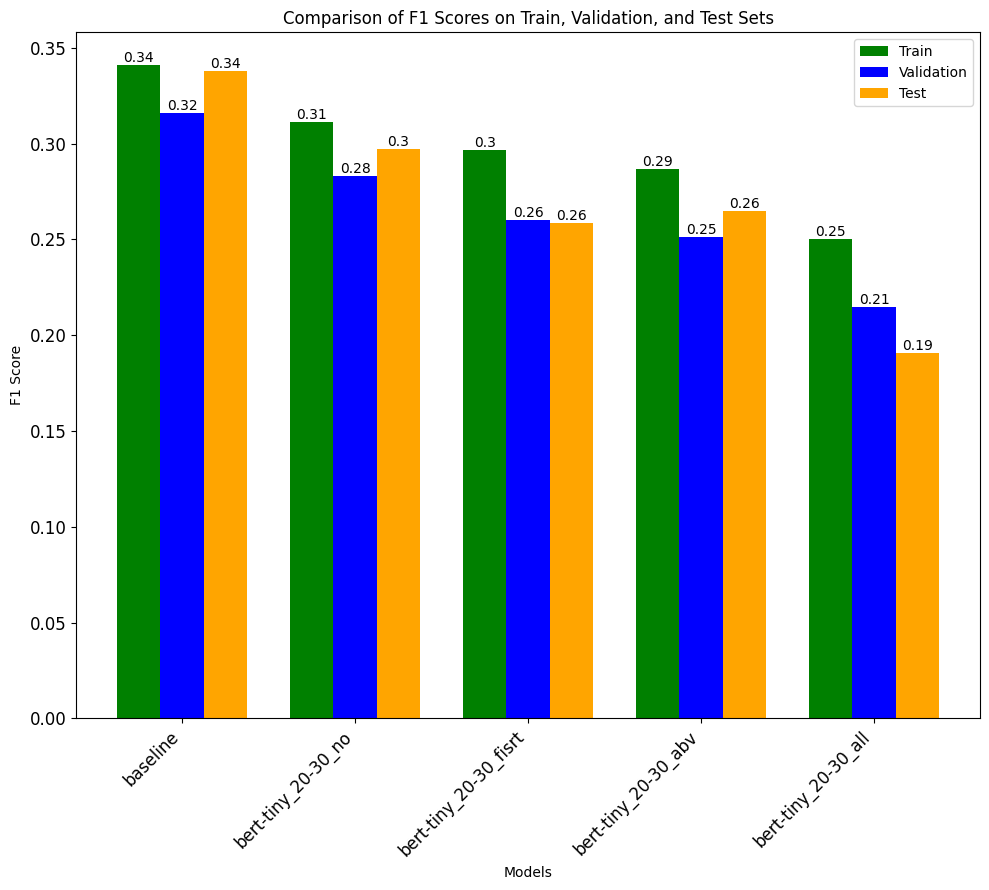

In [51]:
plot_f1(tinytrans, 'tiny');

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


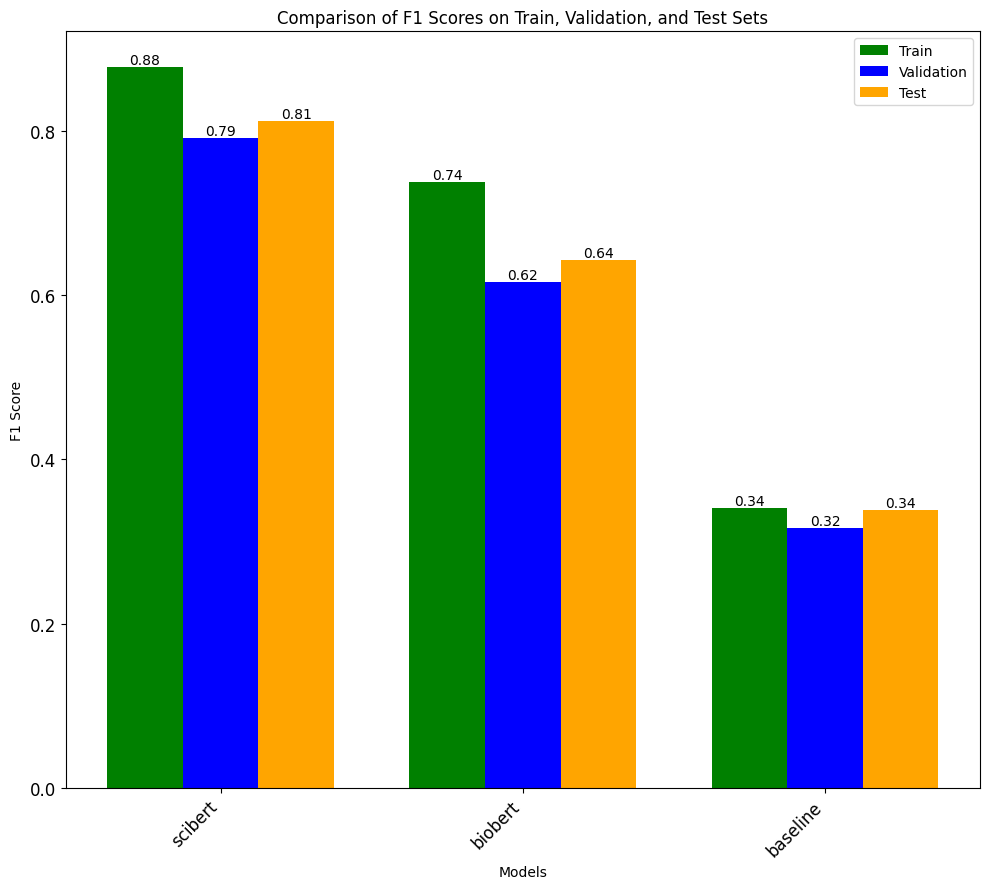

In [45]:
plot_f1(bioscitrans, 'biosci');

In [ ]:
best_model = bioscitrans[0]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


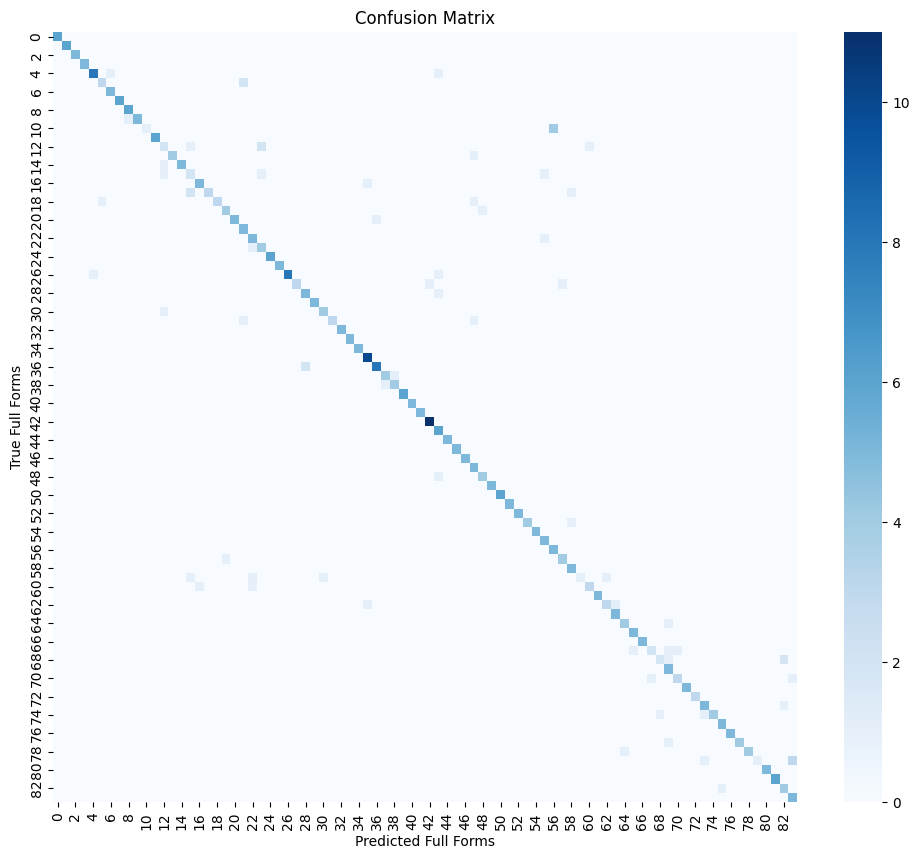

In [55]:
split = 'test'
# Get unique full forms
unique_full_forms = list(np.unique(best_model['y_true'][split]))
# Compute confusion matrix
cm = confusion_matrix(best_model['y_true'][split], best_model['y_pred'][split], labels=unique_full_forms)

# Create confusion matrix plot
plt.figure(figsize=(12, 10))
sns.heatmap(cm, cmap='Blues', fmt='d')
plt.xlabel('Predicted Full Forms')
plt.ylabel('True Full Forms')
plt.title('Confusion Matrix')
plt.savefig('confusion-matrix.png', dpi=1000)
plt.show()

In [ ]:
# Get unique abbreviations
unique_abv = np.unique(best_model['abv'][split])
# Loop through each abbreviation
for i, abv in enumerate(unique_abv):
    # Get true and predicted labels for the current abbreviation
    y_true = [best_model['y_true'][split][i] for i in range(len(best_model['y_true'][split])) if
              abv == best_model['abv'][split][i]]
    y_pred = [best_model['y_pred'][split][i] for i in range(len(best_model['y_true'][split])) if
              abv == best_model['abv'][split][i]]

    # Generate classification report for the current abbreviation
    report = classification_report(y_true, y_pred, labels=np.unique(y_true))

    # Print the classification report
    print(f"{abv} - Original Versions:")
    print(report)
    print()#%% md
## Preparing the notebook

#### ABV prompt

In [ ]:
bert = TrasformerModel(ModelName.BERT_TINY, which_prompts=Prompts.ABV, num_train_epochs=8)
bert.train_model();

#### ALL prompts

In [ ]:
bert = TrasformerModel(ModelName.BERT_TINY, which_prompts=Prompts.ALL, num_train_epochs=8)
bert.train_model();

In [ ]:
bert.evaluate(bert.train_dataloader)

### BIOBERT

In [ ]:
bio_bert = TrasformerModel(ModelName.BIOBERT_LAB)

In [ ]:
bio_bert.train_model();

### SCI-BERT

In [ ]:
% % capture
sci_bert = TrasformerModel(ModelName.SCIBERT, which_prompts=Prompts.NO, num_train_epochs=2)

In [ ]:
sci_bert.train_model();

## Evaluation

In [ ]:
tinytrans = [
    {
        'name': f'{transformer_name}_20-30_{which_prompts}',
        'model': TrasformerModel(ModelName.BERT_TINY, which_prompts=which_prompts,
                                 path_to_model=os.path.join(Path.BASE, f'{transformer_name}_20-30_{which_prompts}',
                                                            'epoch_7', 'pytorch_model.bin'))
    } for which_prompts in [Prompts.NO, Prompts.FIRST, Prompts.ABV, Prompts.ALL] for transformer_name in ['tiny']
]

In [ ]:
bioscitrans = [
    {
        'name': f'{transformer_name}_20-30_no',
        'model': TrasformerModel(ModelName.SCIBERT if transformer_name == 'scibert' else ModelName.BIOBERT,
                                 which_prompts=Prompts.NO,
                                 path_to_model=os.path.join(Path.BASE, f'{transformer_name}_20-30_no', 'epoch_1',
                                                            'pytorch_model.bin'))
    }
    for transformer_name in ['biobert', 'scibert']
]

In [ ]:
def create_transformers(transformers):
    transformers.append(
        {
            'name': 'baseline'
        }
    )
    for transformer in transformers:
        name = 'name'
        print(f'Working on {transformer[name]}:')
        if transformer['name'] == 'baseline':
            true_train, pred_train, abv_train = baseline(train_dataset)
            true_valid, pred_valid, abv_valid = baseline(val_dataset)
            true_test, pred_test, abv_test = baseline(test_dataset)
        else:
            true_train, pred_train, abv_train = transformer['model'].predict(transformer['model'].train_dataloader)
            true_valid, pred_valid, abv_valid = transformer['model'].predict(transformer['model'].valid_dataloader)
            true_test, pred_test, abv_test = transformer['model'].predict(transformer['model'].test_dataloader)

        for key in ['y_true', 'y_pred', 'abv']:
            transformer['y_true'] = {
                'train': true_train,
                'valid': true_valid,
                'test': true_test,
            }
            transformer['y_pred'] = {
                'train': pred_train,
                'valid': pred_valid,
                'test': pred_test,
            }

            transformer['abv'] = {
                'train': abv_train,
                'valid': abv_valid,
                'test': abv_test,
            }
    for transformer in transformers:
        if transformer['name'] == 'baseline':
            continue
        for key in ['y_true', 'y_pred']:
            transformer[key] = {
                split: list(
                    map(lambda label_index, abv: abv2labels[abv][label_index] if len(abv2labels[abv]) > label_index else
                    abv2labels[abv][0], transformer[key][split], transformer['abv'][split]))
                for split in ['train', 'valid', 'test']
            }
    for transformer in transformers:
        for score, score_func in zip(['precision', 'f1', 'recall'],
                                     [tool.precision_score, tool.f1_score, tool.recall_score]):
            transformer[score] = {
                split: score_func(transformer['y_true'][split], transformer['y_pred'][split], average='macro',
                                  zero_division=0)
                for split in ['train', 'valid', 'test']
            }
    for transformer in transformers:
        try:
            del transformer['model']
        except:
            pass
    return transformers

In [ ]:
transformers = create_transformers(transformers)

In [ ]:
bioscitrans = create_transformers(bioscitrans)

In [ ]:
with open(f'drive/MyDrive/trans_info_tiny.pickle', 'wb') as handle:
    pickle.dump(tinytrans, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open(f'drive/MyDrive/trans_info_biosci.pickle', 'wb') as handle:
    pickle.dump(bioscitrans, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
with open(f'drive/MyDrive/trans_info_tiny.pickle', 'rb') as handle:
    tinytrans = pickle.load(handle)
with open(f'drive/MyDrive/trans_info_biosci.pickle', 'rb') as handle:
    bioscitrans = pickle.load(handle)

In [ ]:
def plot_f1(trans_info, save_to=None):
    # Extract model names, train F1 scores, validation F1 scores, and test F1 scores
    model_names = []
    train_f1_scores = []
    valid_f1_scores = []
    test_f1_scores = []

    for transformer in trans_info:
        model_names.append(transformer['name'])
        train_f1_scores.append(transformer['f1']['train'])
        valid_f1_scores.append(transformer['f1']['valid'])
        test_f1_scores.append(transformer['f1']['test'])

    # Set the bar width
    bar_width = 0.25

    # Create the plot
    plt.figure(figsize=(10, 9))

    # Plot train F1 scores
    train_bars = plt.bar([x + (0 * bar_width) for x in range(len(model_names))], train_f1_scores, width=bar_width,
                         label='Train', color='green')

    # Plot validation F1 scores
    valid_bars = plt.bar([x + (1 * bar_width) for x in range(len(model_names))], valid_f1_scores, width=bar_width,
                         label='Validation', color='blue')

    # Plot test F1 scores
    test_bars = plt.bar([x + (2 * bar_width) for x in range(len(model_names))], test_f1_scores, width=bar_width,
                        label='Test', color='orange')

    # Add quantity text on top of each bar
    def add_quantity_text(bars):
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width() / 2, height, str(round(height, 2)), ha='center', va='bottom')

    add_quantity_text(train_bars)
    add_quantity_text(valid_bars)
    add_quantity_text(test_bars)

    # Add a horizontal line at the average F1 score
    for i, score in enumerate(valid_f1_scores):
        if model_names[i] != 'baseline':
            try:
                model_names[i] = model_names[i].split('/')[1]
            except:
                model_names[i] = model_names[i].split('_')[0]

    # Set x-axis ticks and labels
    # Set the fontsize of the tick labels on the x-axis and y-axis
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.xticks([x + bar_width for x in range(len(model_names))], model_names, rotation=45, ha='right')

    # Set labels and title
    plt.xlabel('Models')
    plt.ylabel('F1 Score')
    plt.title('Comparison of F1 Scores on Train, Validation, and Test Sets')

    # Setting the vertical axis limit
    # plt.ylim(0, 1)

    # Add legend
    plt.legend()

    # Show the plot
    plt.tight_layout()
    if save_to:
        plt.savefig(f'{save_to}.png', dpi=1000)
    plt.show()



In [ ]:
plot_f1(tinytrans, 'tiny');

In [ ]:
plot_f1(bioscitrans, 'biosci');

In [ ]:
best_model = bioscitrans[0]

In [ ]:
# Get unique full forms
unique_full_forms = list(np.unique(best_model['y_true'][split]))
split = 'test'
# Compute confusion matrix
cm = confusion_matrix(best_model['y_true'][split], best_model['y_pred'][split], labels=unique_full_forms)

# Create confusion matrix plot
plt.figure(figsize=(12, 10))
sns.heatmap(cm, cmap='Blues', fmt='d')
plt.xlabel('Predicted Full Forms')
plt.ylabel('True Full Forms')
plt.title('Confusion Matrix')
plt.savefig('confusion-matrix.png', dpi=1000)
plt.show()

In [ ]:
# Get unique abbreviations
unique_abv = np.unique(best_model['abv'][split])
# Loop through each abbreviation
for i, abv in enumerate(unique_abv):
    # Get true and predicted labels for the current abbreviation
    y_true = [best_model['y_true'][split][i] for i in range(len(best_model['y_true'][split])) if
              abv == best_model['abv'][split][i]]
    y_pred = [best_model['y_pred'][split][i] for i in range(len(best_model['y_true'][split])) if
              abv == best_model['abv'][split][i]]

    # Generate classification report for the current abbreviation
    report = classification_report(y_true, y_pred, labels=np.unique(y_true))

    # Print the classification report
    print(f"{abv} - Original Versions:")
    print(report)
    print()



## Error Analysis

### Finding significant errors

In [ ]:
true_label22wrong_label2freq = {}
true2wrong_label = {}
for true_label, pred_label, abv in zip(best_model['y_true'][split], best_model['y_pred'][split], best_model['abv'][split]):
    if true_label != pred_label:
        wrong_label2freq = true_label22wrong_label2freq.get((true_label, abv), {})
        wrong_label2freq[pred_label] = wrong_label2freq.get(pred_label, 0) + 1
        true_label22wrong_label2freq[(true_label, abv)] = wrong_label2freq
for true_label, wrong_label2freq in true_label22wrong_label2freq.items():
    for wrong_label, freq in wrong_label2freq.items():
        if freq > 1:
            true2wrong_label[true_label] = (wrong_label, freq)
true2wrong_label = dict(sorted(true2wrong_label.items(), key=lambda x: x[1][1]))
true2wrong_label

### Post processing

In [ ]:
bad_label2good_label = {
    'sinusoidally amplitudemodulated': 'amplitude modulated',
    'paf acetylhydrolase': 'acetylhydrolase',
    'anteromedial nucleus': 'anteromedial',
    'acetoxymethyl ester': 'acetoxymethyl',
    'arbuscular mycorrhizal': 'arbuscular mycorrhiza',
}

In [ ]:
for i in range(len(best_model['y_true'][split])):
    if best_model['y_true'][split][i] in bad_label2good_label.keys():
        best_model['y_true'][split][i] = bad_label2good_label[best_model['y_true'][split][i]]
    if best_model['y_pred'][split][i] in bad_label2good_label.keys():
        best_model['y_pred'][split][i] = bad_label2good_label[best_model['y_pred'][split][i]]

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report


# Loop through each abbreviation
for i, abv in enumerate(['AM']):

    # Get true and predicted labels for the current abbreviation
    y_true = [best_model['y_true'][split][i] for i in range(len(best_model['y_true'][split])) if abv==best_model['abv'][split][i]]
    y_pred = [best_model['y_pred'][split][i] for i in range(len(best_model['y_true'][split])) if abv==best_model['abv'][split][i]]

    # Generate classification report for the current abbreviation
    report = classification_report(y_true, y_pred, labels=np.unique(y_true))

    # Print the classification report
    print(f"{abv} - Original Versions:")
    print(report)
    print()



In [ ]:
true_label22wrong_label2freq = {}
true2wrong_label = {}
for true_label, pred_label, abv in zip(best_model['y_true'][split], best_model['y_pred'][split], best_model['abv'][split]):
    if true_label != pred_label:
        wrong_label2freq = true_label22wrong_label2freq.get((true_label, abv), {})
        wrong_label2freq[pred_label] = wrong_label2freq.get(pred_label, 0) + 1
        true_label22wrong_label2freq[(true_label, abv)] = wrong_label2freq
for true_label, wrong_label2freq in true_label22wrong_label2freq.items():
    for wrong_label, freq in wrong_label2freq.items():
        if freq > 1:
            true2wrong_label[true_label] = (wrong_label, freq)
true2wrong_label = dict(sorted(true2wrong_label.items(), key=lambda x: x[1][1]))
true2wrong_label

## Error Analysis

### Finding significant errors

In [30]:
true_label22wrong_label2freq = {}
true2wrong_label = {}
for true_label, pred_label, abv in zip(best_model['y_true'][split], best_model['y_pred'][split], best_model['abv'][split]):
    if true_label != pred_label:
        wrong_label2freq = true_label22wrong_label2freq.get((true_label, abv), {})
        wrong_label2freq[pred_label] = wrong_label2freq.get(pred_label, 0) + 1
        true_label22wrong_label2freq[(true_label, abv)] = wrong_label2freq
for true_label, wrong_label2freq in true_label22wrong_label2freq.items():
    for wrong_label, freq in wrong_label2freq.items():
        if freq > 1:
            true2wrong_label[true_label] = (wrong_label, freq)
true2wrong_label = dict(sorted(true2wrong_label.items(), key=lambda x: x[1][1]))
true2wrong_label

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


{('adult', 'AD'): ('alzheimertype dementia', 2),
 ('benzamide', 'BA'): ('nbenzyladenine', 2),
 ('amplitude modulated', 'AM'): ('sinusoidally amplitudemodulated', 2),
 ('paf acetylhydrolase', 'AH'): ('alveolar hemorrhage', 2),
 ('anteromedial nucleus', 'AM'): ('amygdaloid', 2),
 ('anteromedial', 'AM'): ('anteromedial nucleus', 2),
 ('alcohol dependence', 'AD'): ('affective disorders', 2),
 ('butyl acrylate', 'BA'): ('nbutyl acrylate', 3),
 ('acetoxymethyl', 'AM'): ('acetoxymethyl ester', 3),
 ('arbuscular mycorrhizal', 'AM'): ('arbuscular mycorrhiza', 4),
 ('adenomatous hyperplasia', 'AH'): ('atypical hyperplasia', 4)}

### Post processing

In [31]:
bad_label2good_label = {
    'sinusoidally amplitudemodulated': 'amplitude modulated',
    'paf acetylhydrolase': 'acetylhydrolase',
    'anteromedial nucleus': 'anteromedial',
    'acetoxymethyl ester': 'acetoxymethyl',
    'arbuscular mycorrhizal': 'arbuscular mycorrhiza',
}

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [32]:
for i in range(len(best_model['y_true'][split])):
    if best_model['y_true'][split][i] in bad_label2good_label.keys():
        best_model['y_true'][split][i] = bad_label2good_label[best_model['y_true'][split][i]]
    if best_model['y_pred'][split][i] in bad_label2good_label.keys():
        best_model['y_pred'][split][i] = bad_label2good_label[best_model['y_pred'][split][i]]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [33]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report


# Loop through each abbreviation
for i, abv in enumerate(['AM']):

    # Get true and predicted labels for the current abbreviation
    y_true = [best_model['y_true'][split][i] for i in range(len(best_model['y_true'][split])) if abv==best_model['abv'][split][i]]
    y_pred = [best_model['y_pred'][split][i] for i in range(len(best_model['y_true'][split])) if abv==best_model['abv'][split][i]]

    # Generate classification report for the current abbreviation
    report = classification_report(y_true, y_pred, labels=np.unique(y_true))

    # Print the classification report
    print(f"{abv} - Original Versions:")
    print(report)
    print()
   


AM - Original Versions:
                         precision    recall  f1-score   support

          acetoxymethyl       0.89      0.80      0.84        10
             actomyosin       0.83      1.00      0.91         5
        adrenal medulla       1.00      1.00      1.00         6
   alternative medicine       0.80      0.80      0.80         5
               alveolar       1.00      0.83      0.91         6
  ambulatory monitoring       1.00      1.00      1.00         6
      amniotic membrane       1.00      1.00      1.00         5
    amplitude modulated       1.00      0.80      0.89        10
   amplitude modulation       1.00      0.60      0.75         5
             amygdaloid       0.71      0.83      0.77         6
           anteromedial       0.89      0.80      0.84        10
        apparent motion       1.00      1.00      1.00         5
  arbuscular mycorrhiza       0.92      1.00      0.96        11
        arithmetic mean       0.60      1.00      0.75         6


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [35]:
true_label22wrong_label2freq = {}
true2wrong_label = {}
for true_label, pred_label, abv in zip(best_model['y_true'][split], best_model['y_pred'][split], best_model['abv'][split]):
    if true_label != pred_label:
        wrong_label2freq = true_label22wrong_label2freq.get((true_label, abv), {})
        wrong_label2freq[pred_label] = wrong_label2freq.get(pred_label, 0) + 1
        true_label22wrong_label2freq[(true_label, abv)] = wrong_label2freq
for true_label, wrong_label2freq in true_label22wrong_label2freq.items():
    for wrong_label, freq in wrong_label2freq.items():
        if freq > 1:
            true2wrong_label[true_label] = (wrong_label, freq)
true2wrong_label = dict(sorted(true2wrong_label.items(), key=lambda x: x[1][1]))
true2wrong_label

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


{('adult', 'AD'): ('alzheimertype dementia', 2),
 ('benzamide', 'BA'): ('nbenzyladenine', 2),
 ('acetylhydrolase', 'AH'): ('alveolar hemorrhage', 2),
 ('anteromedial', 'AM'): ('amygdaloid', 2),
 ('alcohol dependence', 'AD'): ('affective disorders', 2),
 ('butyl acrylate', 'BA'): ('nbutyl acrylate', 3),
 ('adenomatous hyperplasia', 'AH'): ('atypical hyperplasia', 4)}